# Whiskey centroids with Apache Wayang

This example examines 86 Scotch whiskies that have been rated on
a five-point scale for 12 flavor characteristics: Body, sweetness, smoky, medicinal, tobacco, honey, spicy, winey, nutty, malty, fruity, and floral.
This data set comes from a book on the classification of Scotch whisky based on
flavors by David Wishart (2002) and can be found [online](https://www.niss.org/sites/default/files/ScotchWhisky01.txt).

In [1]:
%%classpath add mvn
org.apache.wayang wayang-api-scala-java_2.12 0.6.0
org.apache.wayang wayang-java 0.6.0
org.knowm.xchart xchart 3.7.0
org.apache.hadoop hadoop-common 3.3.3
org.scala-lang scala-library 2.12.15

In [2]:
%import java.awt.Color

Centroids:
Cluster0: 2.278, 2.611, 1.167, 0.056, 0.056, 1.944, 1.611, 1.556, 1.278, 2.111, 2.278, 1.889
Cluster1: 2.040, 2.000, 1.800, 0.640, 0.160, 1.360, 1.480, 0.880, 1.800, 1.800, 1.400, 1.640
Cluster2: 1.276, 2.517, 1.000, 0.241, 0.034, 0.862, 1.000, 0.379, 1.207, 1.759, 1.862, 2.138
Cluster3: 3.571, 2.286, 1.857, 0.143, 0.000, 1.714, 1.714, 2.857, 2.000, 1.571, 2.286, 1.143
Cluster4: 3.429, 1.571, 3.429, 3.143, 0.571, 0.143, 1.714, 0.429, 1.286, 1.429, 1.286, 0.143


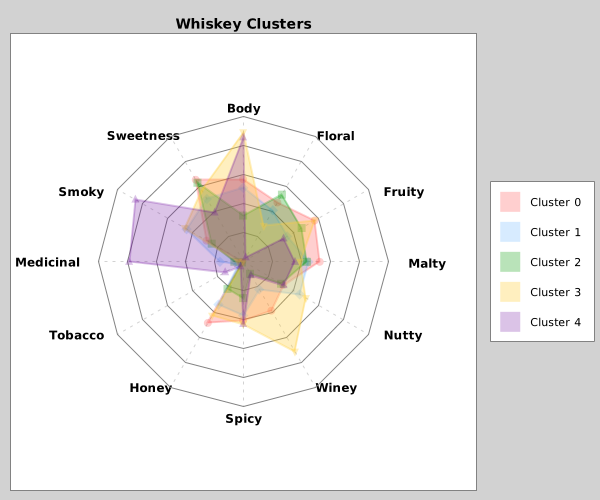

In [ ]:
import groovy.transform.TupleConstructor
import org.apache.wayang.core.api.Configuration
import org.apache.wayang.core.api.WayangContext
import org.apache.wayang.core.function.ExecutionContext
import org.apache.wayang.core.function.FunctionDescriptor.ExtendedSerializableFunction
import org.apache.wayang.java.Java
import org.apache.wayang.api.JavaPlanBuilder
import org.knowm.xchart.*
import static java.lang.Math.sqrt

class Point { double[] pts }

@TupleConstructor(includeSuperProperties=true)
class TaggedPointCounter extends Point {
    int cluster
    long count
    TaggedPointCounter plus(TaggedPointCounter other) {
        new TaggedPointCounter((0..<pts.size()).collect{ pts[it] + other.pts[it] } as double[], cluster, count + other.count)
    }
    TaggedPointCounter average() {
        new TaggedPointCounter(pts.collect{ it/count } as double[], cluster, 0)
    }
}

class SelectNearestCentroid implements ExtendedSerializableFunction<Point, TaggedPointCounter> {
    Iterable<TaggedPointCounter> centroids

    void open(ExecutionContext context) {
        centroids = context.getBroadcast("centroids")
    }

    TaggedPointCounter apply(Point p) {
        def minDistance = Double.POSITIVE_INFINITY
        def nearestCentroidId = -1
        for (c in centroids) {
            def distance = sqrt((0..<p.pts.size()).collect{ p.pts[it] - c.pts[it] }.sum{ it ** 2 })
            if (distance < minDistance) {
                minDistance = distance
                nearestCentroidId = c.cluster
            }
        }
        new TaggedPointCounter(p.pts, nearestCentroidId, 1)
    }
}

int k = 5
int iterations = 20
def cols = ["Body", "Sweetness", "Smoky", "Medicinal", "Tobacco", "Honey",
        "Spicy", "Winey", "Nutty", "Malty", "Fruity", "Floral"]
def url = '../resources/whiskey.csv'
def pointsData = new File(url).readLines()[1..-1].collect{ new Point(pts: it.split(",")[2..-1]*.toDouble()) }
def dims = pointsData[0].pts.size()

def r = new Random()
double[][] initPts = (1..k).collect{ (0..<dims).collect{ r.nextGaussian() + 2 } }

def config = new Configuration()
def context = new WayangContext(config).withPlugin(Java.basicPlugin())

def planBuilder = new JavaPlanBuilder(context, "KMeans ($url, k=$k, iterations=$iterations)")

def points = planBuilder
    .loadCollection(pointsData)

def initialCentroids = planBuilder
    .loadCollection((0..<k).collect{new TaggedPointCounter(initPts[it], it, 0)})
    .withName("Load random centroids")

def finalCentroids = initialCentroids.repeat(iterations, { currentCentroids ->
    points.map(new SelectNearestCentroid())
        .withBroadcast(currentCentroids, "centroids").withName("Find nearest centroid")
        .reduceByKey({ tpc -> tpc.cluster }, { tpc1, tpc2 -> tpc1.plus(tpc2) }).withName("Add up points")
        .map({ tpc -> tpc.average() }).withName("Average points").withOutputClass(TaggedPointCounter)
}).withName("Loop").collect()

RadarChart chart = new RadarChartBuilder().width(600).height(500).title('Whiskey Clusters').build()
chart.variableLabels = cols as String[]
chart.styler.with {
    legendVisible = true
    seriesColors = [new Color(255, 51, 51, 60),
                    new Color(51, 153, 255, 50),
                    new Color(0, 153, 0, 70),
                    new Color(255, 204, 51, 80),
                    new Color(102, 0, 153, 60)] as Color[]
}

println 'Centroids:'
finalCentroids.each { c ->
    println "Cluster$c.cluster: ${c.pts.collect{ sprintf('%.3f', it) }.join(', ')}"
    chart.addSeries("Cluster $c.cluster", c.pts.collect{ it/4 } as double[])
}

BitmapEncoder.getBufferedImage(chart)